# Figure for Polybench

In [103]:
import re


def process_time(time):
    res = 0
    time = time.split('m')

    if len(time) != 1:
        res += float(time[0]) * 60000
    time = time[-1]

    if 'ms' in time:
        time = float(re.sub(r'ms.*\n', '', time))
        res += time
    elif 'ns' in time:
        time = float(re.sub(r'ns.*\n', '', time)) * 1e-6
        res += time
    elif 's' in time:
        time = float(re.sub(r's.*\n', '', time)) * 1000
        res += time

    return res


def extract_elapsed_ms(file, type):
    ans = []
    init_time = 0
    with open(file, "r", encoding="utf-8", errors="ignore") as file:
        for line in file:
            if ("time" in line or "Time" in line or "Elapsed" in line) and 'time...' not in line and '...' not in line:
                splitted = line.split(" ")
                time = splitted[-1]

                ans.append(process_time(time))
            elif ('initialization takes' in line or 'Initialization takes' in line) and type == 'mt':
                splitted = line.split(' ')
                time = splitted[-1]
                init_time = process_time(time)
                ans.append(init_time)
            # Calculate real time.
            elif 'real' in line and type == 'mt':
                splitted = line.split('\t')
                time = splitted[-1]
                time = process_time(time)
                ans.append(time)

    if ans == []:
        raise Exception("Could not find time in file")
    else:
        return ans


In [2]:
# def extract(file, task_identifier):
#     for line in open(file, "r"):
#         if task_identifier in line:
#             return int(line.split(" ")[-2])

#     raise Exception("Could not find %s in file", task_identifier)


In [3]:
import os


def polypench_analyze(focused):
    result = {}
    path = "../data/task_polybench/"
    for dirname, subdirlist, filelist in os.walk(path):
        if dirname == path:
            for dir in subdirlist:
                result[dir] = []
            continue

        # skip root directory is skipped
        for fname in filelist:
            subtask = os.path.basename(os.path.normpath(dirname))
            if focused in fname:
                data = extract_elapsed_ms(dirname + "/" + fname)
                result[subtask].extend(data)

    return result


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

poly_native = polypench_analyze("enclave_native")
poly_native = pd.DataFrame(poly_native)
poly_native = poly_native.transpose()

poly_pobf = polypench_analyze("enclave_pobf")
poly_pobf = pd.DataFrame(poly_pobf)
poly_pobf = poly_pobf.transpose()

poly = {}
poly["native"] = {}
poly["pobf"] = {}

for i in poly_native.index:
    poly["native"][i] = np.average(poly_native.loc[i])
    poly["pobf"][i] = np.average(poly_pobf.loc[i])

poly = pd.DataFrame(poly)
for i in poly.index:
    poly.loc[i, "overhead"] = (
        (poly.loc[i, "pobf"] / poly.loc[i, "native"]) - 1) * 100

np.average(poly["overhead"])


KeyError: 'overhead'

In [ ]:
sns.set(style="whitegrid")
xs = []
ys = []
hue = []
overhead = []
for i in poly.index:
    xs.append(i)
    xs.append(i)
    ys.append(poly["native"][i])
    ys.append(poly["pobf"][i])
    hue.append("Native")
    hue.append("PoCF")

assert (len(xs) == len(ys))
g = sns.barplot(x=xs, y=ys, hue=hue)
# g.set_yscale("log")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

overhead_precentage = "  " + poly["overhead"].round(1).astype(str)

g.bar_label(g.containers[0], labels=overhead_precentage, fontsize=7, padding=3)
g.set_ylabel("Time (ms)", fontsize=12)
plt.savefig("../polybench.pdf", bbox_inches='tight')


In [ ]:
poly.overhead.mean()


# Figure for Identity Function

In [5]:
def identity_analyze(focused):
    result = []
    path = "../data/task_sample/"
    for dirname, subdirlist, filelist in os.walk(path):
        if dirname != path:
            break
        for f in filelist:
            if focused in f:
                result.extend(extract_elapsed_ms(path + f,))
    return result


In [6]:
datasizes = {"1kb": 1000, "10kb": 10000, "100kb": 100000,
             "1mb": 1000000, "10mb": 10000000, "100mb": 100000000}

identifiers = ["native", "pobf"]
identity = {id: {} for id in identifiers}

for size_str in datasizes:
    for id in identifiers:
        file_partial_name = size_str + "output_enclave_" + id + ".txt"
        data = identity_analyze(file_partial_name)
        assert (len(data) == 10)
        identity[id][size_str] = np.average(data)

identity = pd.DataFrame(identity)
for i in identity.index:
    identity.loc[i, "overhead"] = (
        (identity.loc[i, "pobf"] / identity.loc[i, "native"]) - 1) * 100

identity.round(3).transpose()


AssertionError: 

In [ ]:
sns.set(style="whitegrid")
xs = []
ys = []
hue = []
overhead = []
for i in identity.index:
    xs.append(i)
    xs.append(i)
    ys.append(identity["native"][i])
    ys.append(identity["pobf"][i])
    hue.append("Native")
    hue.append("PoCF")

assert (len(xs) == len(ys))
g = sns.lineplot(x=xs, y=ys, hue=hue, markers=True)
g.set_yscale("log")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

overhead_precentage = " " + identity["overhead"].round(1).astype(str)

# g.bar_label(g.containers[0], labels = overhead_precentage, fontsize=7, padding=3)
g.set_ylabel("Time (ms)", fontsize=12)
plt.savefig("../polybench.pdf", bbox_inches='tight')


# Figure for Macrobenchmarks

In [126]:
import os

# Analyze single-threaded macrobenchmarks.


def analyze_macrobenchmarks(focused, type, pos=-1):
    result = {}
    throughput = {}
    # Tasks.
    tasks = ["task_tvm", "task_fasta"]

    for task in tasks:
        path = "../data/" + task + "/"
        result[task] = []
        for dirname, subdirlist, filelist in os.walk(path):
            for fname in filelist:
                if focused in fname:
                    if (type == 'st' and 'mt_' not in fname) or (type == 'mt' and 'mt_' in fname):
                        data = extract_elapsed_ms(dirname + "/" + fname, type)
                        if type == 'st':
                            result[task].extend(data)
                        elif type == 'mt':
                            result[task].append(data)

        # Calculate throughput for multithreaded programs.
        if type == 'mt':
            # 2 stands for init + real.
            # [init_time, xxx, xxx, real_time] or [xxx, xxx, real_time, init_time]
            requests = len(result[task][0]) - 2
            test_suites = len(result[task])
            real_time = 0

            print("task:", task, result[task])
            for test in result[task]:
                real_time += abs(test[pos] - test[-1])
                print(test[pos], test[-1])
            real_time /= test_suites
            throughput[task] = []
            throughput[task].append(real_time / requests)

        result[task] = np.average(result[task])

    return result, throughput


## Plot single-threaded - TVM

/tmp/ipykernel_129831/177265097.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), size=16)


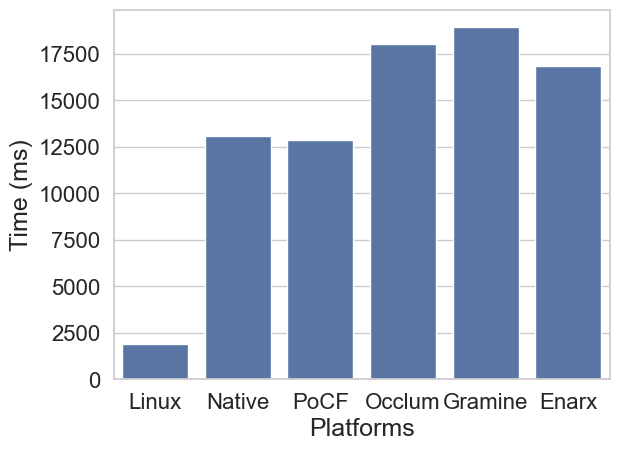

In [166]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

platforms = ['rust', 'native', 'pobf', 'occlum', 'gramine', 'enarx']

ys = []
for platform in platforms:
    cur, _ = analyze_macrobenchmarks('data_provider_' + platform, 'st')
    for k, v in cur.items():
        ys.append(v)

sns.set(style='whitegrid')
xs =  ['Linux', 'Native', 'PoCF', 'Occlum', 'Gramine', 'Enarx']

g = sns.barplot(x=xs, y=ys[::2], color='b')
g.set_ylabel('Time (ms)', fontsize=18)
g.set_xlabel('Platforms', fontsize=18)
g.set_xticklabels(g.get_xticklabels(), size=16)
g.set_yticklabels(g.get_yticklabels(), size=16)
plt.savefig("../macrobenchmarks_st_tvm.pdf", bbox_inches='tight')


## Plot single-threaded - FASTA

/tmp/ipykernel_129831/1611725806.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), size=16)


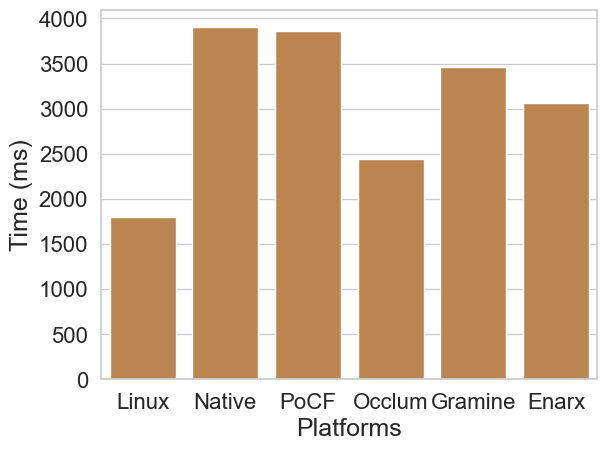

In [169]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

platforms = ['rust', 'native', 'pobf', 'occlum', 'gramine', 'enarx']

ys = []
for platform in platforms:
    cur, _ = analyze_macrobenchmarks('data_provider_' + platform, 'st')
    for k, v in cur.items():
        ys.append(v)

sns.set(style='whitegrid')
xs =  ['Linux', 'Native', 'PoCF', 'Occlum', 'Gramine', 'Enarx']

g = sns.barplot(x=xs, y=ys[1::2], color='peru')
g.set_ylabel('Time (ms)', fontsize=18)
g.set_xlabel('Platforms', fontsize=18)
g.set_xticklabels(g.get_xticklabels(), size=16)
g.set_yticklabels(g.get_yticklabels(), size=16)
plt.savefig("../macrobenchmarks_st_fasta.pdf", bbox_inches='tight')


## Plot multi-threaded - TVM

task: task_tvm [[1886.95588, 1919.71776, 2033.0, 3.86787]]
2033.0 3.86787
task: task_fasta [[2661.468725, 2667.51959, 2673.635613, 2674.7959739999997, 2692.8287609999998, 2677.226725, 2689.834804, 2681.4738359999997, 2818.0, 3.833656]]
2818.0 3.833656
task: task_tvm [[38314.299484, 19359.558702000002, 19367.835719, 58534.0]]
38314.299484 58534.0
task: task_fasta [[38355.201329999996, 5576.0267460000005, 5605.2120429999995, 5816.340291, 5817.0933319999995, 6054.3262159999995, 6059.954651, 6227.948794, 6256.772999, 45984.0]]
38355.201329999996 45984.0
task: task_tvm [[38703.326295, 19437.734145, 19440.51182, 59009.0]]
38703.326295 59009.0
task: task_fasta [[36829.716503999996, 5611.116754000001, 5786.080575999999, 5948.209874, 6155.397784, 6345.346942, 6519.980033000001, 6547.1494330000005, 6573.889178, 44858.0]]
36829.716503999996 44858.0
task: task_tvm [[22055.230685000002, 27396.629765, 73054.0, 44082.955106999994]]
73054.0 44082.955106999994
task: task_fasta [[2305.002365, 2564.63137

/tmp/ipykernel_129831/713205915.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), size=16)


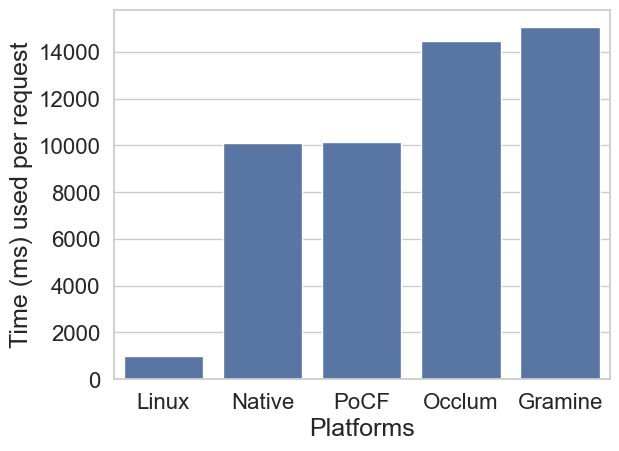

In [171]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

platforms = ['rust', 'native', 'pobf', 'occlum', 'gramine']

ys = []
for platform in platforms:
    pos = -2
    if platform == 'pobf' or platform == 'native':
          pos = 0
    _, trpt = analyze_macrobenchmarks('output_enclave_' + platform, 'mt', pos=pos)
    for k,v in trpt.items():
        ys.append(v[0])

sns.set(style='whitegrid')
xs = ['Linux', 'Native', 'PoCF', 'Occlum', 'Gramine']

g = sns.barplot(x=xs, y=ys[::2], color='b')
g.set_ylabel('Time (ms) used per request', fontsize=18)
g.set_xlabel('Platforms', fontsize=18)
g.set_xticklabels(g.get_xticklabels(), size=16)
g.set_yticklabels(g.get_yticklabels(), size=16)
plt.savefig("../macrobenchmarks_mt_tvm.pdf", bbox_inches='tight')


## Plot Multi-threaded - FASTA

task: task_tvm [[1886.95588, 1919.71776, 2033.0, 3.86787]]
2033.0 3.86787
task: task_fasta [[2661.468725, 2667.51959, 2673.635613, 2674.7959739999997, 2692.8287609999998, 2677.226725, 2689.834804, 2681.4738359999997, 2818.0, 3.833656]]
2818.0 3.833656
task: task_tvm [[38314.299484, 19359.558702000002, 19367.835719, 58534.0]]
38314.299484 58534.0
task: task_fasta [[38355.201329999996, 5576.0267460000005, 5605.2120429999995, 5816.340291, 5817.0933319999995, 6054.3262159999995, 6059.954651, 6227.948794, 6256.772999, 45984.0]]
38355.201329999996 45984.0
task: task_tvm [[38703.326295, 19437.734145, 19440.51182, 59009.0]]
38703.326295 59009.0
task: task_fasta [[36829.716503999996, 5611.116754000001, 5786.080575999999, 5948.209874, 6155.397784, 6345.346942, 6519.980033000001, 6547.1494330000005, 6573.889178, 44858.0]]
36829.716503999996 44858.0
task: task_tvm [[22055.230685000002, 27396.629765, 73054.0, 44082.955106999994]]
73054.0 44082.955106999994
task: task_fasta [[2305.002365, 2564.63137

/tmp/ipykernel_129831/1854230224.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), size=16)


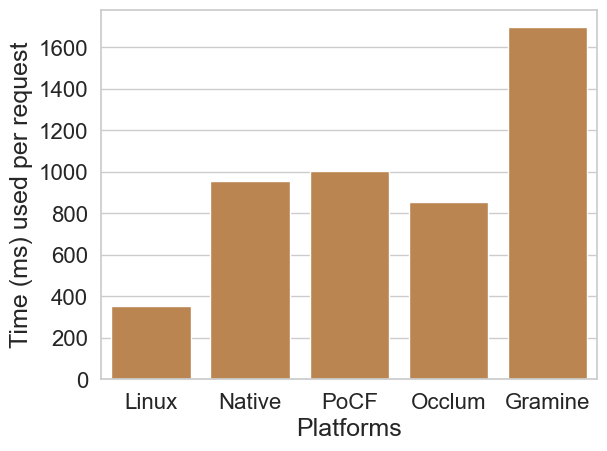

In [170]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

platforms = ['rust', 'native', 'pobf', 'occlum', 'gramine']

ys = []
for platform in platforms:
    pos = -2
    if platform == 'pobf' or platform == 'native':
          pos = 0
    _, trpt = analyze_macrobenchmarks('output_enclave_' + platform, 'mt', pos=pos)
    for k,v in trpt.items():
        ys.append(v[0])


sns.set(style='whitegrid')
xs = ['Linux', 'Native', 'PoCF', 'Occlum', 'Gramine']

g = sns.barplot(x=xs, y=ys[1::2], color='peru')
g.set_ylabel('Time (ms) used per request', fontsize=18)
g.set_xlabel('Platforms', fontsize=18)
g.set_xticklabels(g.get_xticklabels(), size=16)
g.set_yticklabels(g.get_yticklabels(), size=16)
plt.savefig("../macrobenchmarks_mt_fasta.pdf", bbox_inches='tight')
